<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载数据" data-toc-modified-id="加载数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据</a></span></li><li><span><a href="#精度-召回率-F" data-toc-modified-id="精度-召回率-F-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>精度-召回率-F</a></span></li><li><span><a href="#加载模型" data-toc-modified-id="加载模型-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>加载模型</a></span></li><li><span><a href="#示例图" data-toc-modified-id="示例图-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>示例图</a></span></li></ul></div>

In [1]:
data_set = '02_prasad'
base_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/05_ellipse_result/'
label_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/04_ellipse_label/'
raw_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{data_set}/01_raw/'

In [2]:
import os 
dirs = os.listdir(base_path)
dirs = [d for d in dirs if d[0]!='.']
dirs.sort()
print(dirs)

['2012_param', '2014_fast', '2017_fast', '2018_high', 'canny', 'proposed']


In [3]:
fnames = os.listdir(label_path)
fnames = [n.split('.')[0] for n in fnames if n[-3:]=='txt']
fnames.sort()
print(fnames[:10])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


# 加载数据

In [4]:
import sys
import imageio

gts = []
raws = []

for name in fnames:
    
    lname = label_path + name + '.txt'
    rname = raw_path + name + '.jpg'
    
    im_raw = imageio.imread(rname)
    raws.append(im_raw)
    
    with open(lname,'r') as f:
        txt = f.read()
        
        ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n')]
        
        gts.append(ells_t)

print(len(raws),len(gts))

198 198


/home/liucc/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


# 精度-召回率-F

In [5]:
import re
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/05_experiments')
from experiment import *

results = dict()

for dd in dirs:
    
    prs = []
    
    if len(os.listdir(base_path + dd))<len(fnames):
        continue
    
    for name in fnames:
        lname = base_path + dd + '/' + name + '.txt'

        with open(lname,'r') as f:
            txt = f.read()
            txt = txt.strip()
            
            txt = re.sub(r'[\f\r\t\v]+',' ',txt)
            if txt!='':
                ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n') if len(l.split(' '))==5]
            
                prs.append(ells_t)
            else:
                prs.append([])
            
    results[dd] = prs
    print(f'Algorithm:{dd}')
    
    precision,recall,F1,pr_ratio,gt_ratio = cal_metrics(prs,gts,0.8)
    
    print('  Precision:%.4f' % precision)
    print('  Recall:   %.4f' % recall)
    print('  F1 Score: %.4f' % F1)
    print('')

Algorithm:2012_param
  Precision:0.3578
  Recall:   0.0957
  F1 Score: 0.1510

Algorithm:2014_fast
  Precision:0.7500
  Recall:   0.1538
  F1 Score: 0.2553

Algorithm:2017_fast
  Precision:0.5702
  Recall:   0.2222
  F1 Score: 0.3198

Algorithm:2018_high
  Precision:0.7393
  Recall:   0.3538
  F1 Score: 0.4786

Algorithm:canny
  Precision:0.6841
  Recall:   0.3684
  F1 Score: 0.4789

Algorithm:proposed
  Precision:0.7760
  Recall:   0.3761
  F1 Score: 0.5066



# 加载模型

In [6]:
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/01_cnn')
from cnn_model import *

model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse_general'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = RestoreNet(channel=1).to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

# 示例图

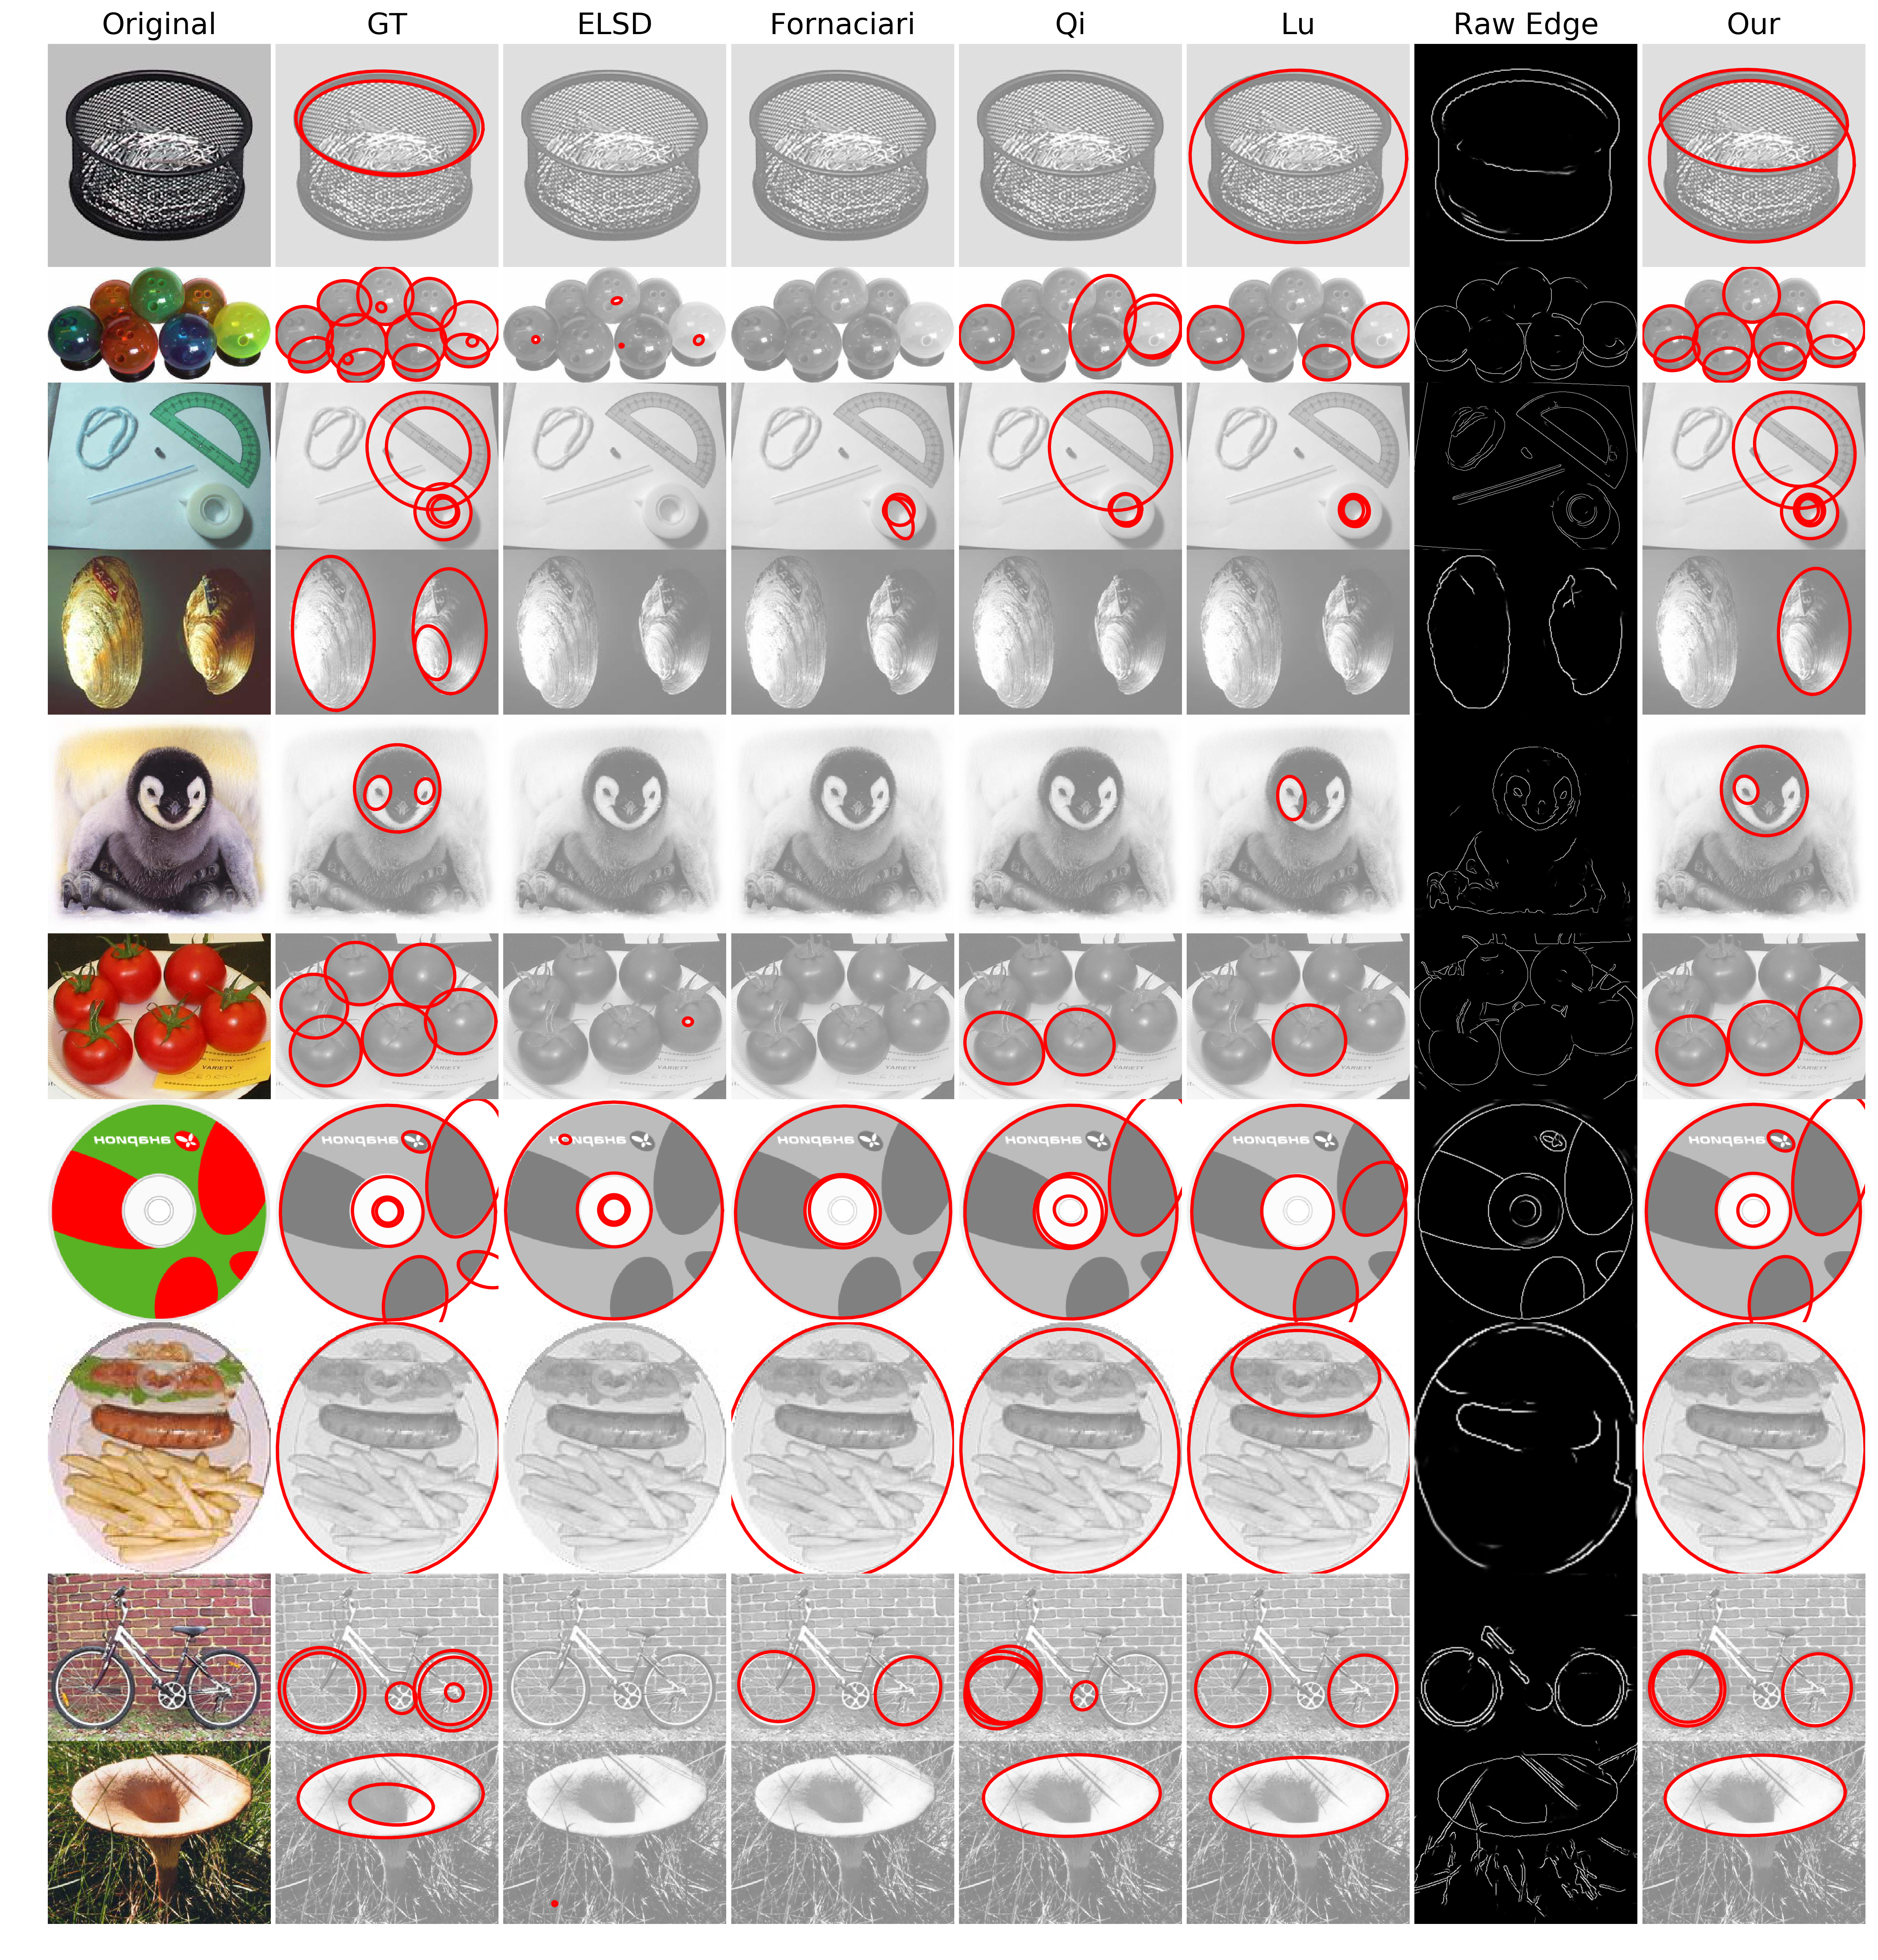

In [16]:
%matplotlib inline
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.color import rgb2gray
from pylab import *
from skimage.morphology import thin

from matplotlib.font_manager import FontProperties
fp = FontProperties(family="DejaVu Sans",size=18)

title = {'2012_param':'ELSD',
         '2014_fast':'Fornaciari',
         '2017_fast':'Qi',
         '2018_high':'Lu',
         'canny':'Our+Canny',
         'Raw Edge':"Edge",
         'Thin Edge':"Thin Edge",
         'proposed':'Our',
         'original':'Original',
         'GT':'GT'}


#examples = [6,9,76,81,104,127,155,157,176,182]
examples = [145, 14, 59, 135, 150, 195, 34, 92, 131, 134]
num = len(examples)

hs = np.array([m.shape[0]/m.shape[1] for m in raws])
hs = hs[examples]

segs = ['2012_param','2014_fast','2017_fast','2018_high','Raw Edge','proposed']
anum = len(segs)+2

fig = plt.figure(figsize=(20,sum(hs)*20/anum+0.1),dpi=300)
gs = gridspec.GridSpec(num,anum,
                       wspace=0.0,
                       hspace=0.0,
                       width_ratios=[1]*anum,
                       height_ratios=hs,
                       )


for i,alg in enumerate(segs):
    
    prs = results[alg]
                      
    for j in range(num):
        
        ax = fig.add_subplot(gs[j,i+2])
        _id = examples[j]
        raw = raws[_id]
        
        if alg=="Thin Edge":
            im = preprocess_image(rgb2gray(raw))
            edge = predict(model,im,device)
            edge = postprocess_image(edge,thr=0.3)
            edge = thin(edge)
            ax.imshow(edge,cmap='gray',interpolation="bilinear")
        elif alg=="Raw Edge":
            im = preprocess_image(rgb2gray(raw))
            edge = predict(model,im,device)
            ax.imshow(edge,cmap='gray',interpolation="bilinear")
        else:
            pr = prs[_id]
            draw_ellipse(pr,ax,'red',1,wire=True)
            gray = rgb2gray(raw)
            ax.imshow(gray,cmap='gray',alpha=0.5)
        
        if j==0:
            ax.set_title(title[alg],fontproperties=fp)
            
        ax.axis('off')
    
for j in range(num):
    ax = fig.add_subplot(gs[j,0])
    
    _id = examples[j]
    if j==0:
        ax.set_title(title['original'],fontproperties=fp)
        
    ax.imshow(raws[_id])
    ax.axis('off')
    
for j in range(num):
    ax = fig.add_subplot(gs[j,1])
    
    _id = examples[j]
    gray = rgb2gray(raws[_id])
    draw_ellipse(gts[_id],ax,'red',1,wire=True)
    if j==0:
        ax.set_title(title['GT'],fontproperties=fp)
        
    ax.imshow(gray,cmap='gray',alpha=0.5)
    ax.axis('off')
    


plt.show()

pp = PdfPages('../images/comparison_prasad.pdf')
pp.savefig(fig,bbox_inches ='tight')
pp.close()